In [172]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from prophet import Prophet
from prophet.plot import plot_plotly, add_changepoints_to_plot
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import ParameterGrid
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
import itertools


In [173]:
def mase(actual, forecast):
    n = len(actual)
    numerator = np.mean(np.abs(actual - forecast))
    denominator = np.mean(np.abs(np.diff(actual)))
    return numerator / denominator

In [174]:
covid_df  = pd.read_csv('penn_uni.csv')
covid_df = covid_df.drop('PROVINCE_STATE_NAME', axis=1)
covid_df['PEOPLE_POSITIVE_NEW_CASES_COUNT'] = np.clip(covid_df['PEOPLE_POSITIVE_NEW_CASES_COUNT'], 0, None)

train_size = int(len(covid_df) * 0.85)
covid_train, covid_test = covid_df[0:train_size], covid_df[train_size:]
covid_train = covid_train.rename(columns={'Date': 'ds', 'PEOPLE_POSITIVE_NEW_CASES_COUNT': 'y'})
covid_test = covid_test.rename(columns={'Date': 'ds', 'PEOPLE_POSITIVE_NEW_CASES_COUNT': 'y'})

In [175]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

## Baseline Univariate

In [176]:
prop_base = Prophet()
prop_base.fit(covid_train)
prop_base_df = prop_base.make_future_dataframe(periods=len(covid_test))
prop_base_pred = prop_base.predict(prop_base_df)
prop_base_train = prop_base.predict(covid_train)
prop_base_test = prop_base.predict(covid_test)

16:09:02 - cmdstanpy - INFO - Chain [1] start processing
16:09:03 - cmdstanpy - INFO - Chain [1] done processing


<AxesSubplot:>

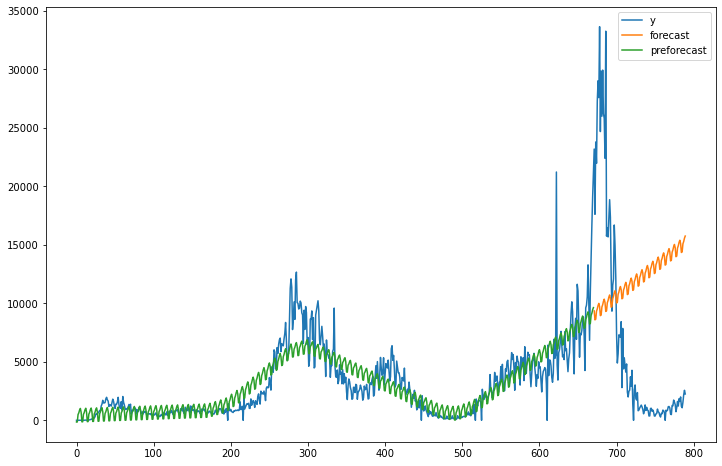

In [177]:
prophet_df_base = pd.DataFrame(covid_df)
prophet_df_base = prophet_df_base.rename(columns={'Date': 'ds', 'PEOPLE_POSITIVE_NEW_CASES_COUNT': 'y'})
prophet_df_base['ds'] = pd.to_datetime(prophet_df_base['ds'])

prophet_df_base['forecast'] = prop_base_test['yhat']
length1 = len(prophet_df_base) - len(prop_base_test)
forecast1 = pd.concat([pd.Series([np.nan] * length1), prop_base_test['yhat']], ignore_index=True)
prophet_df_base['forecast'] = forecast1

prophet_df_base['preforecast']=prop_base_train['yhat']

prophet_df_base[['y','forecast', 'preforecast']].plot(figsize=(12,8))

Text(0, 0.5, 'Count')

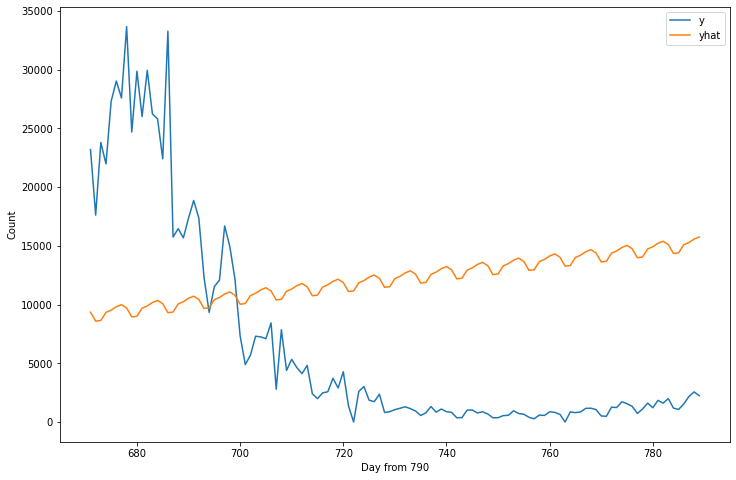

In [178]:
graph_df = pd.DataFrame(covid_test)
graph_df['yhat'] = prop_base_test['yhat'].values
graph_df[['y','yhat']].plot(figsize=(12,8))
plt.xlabel('Day from 790')
plt.ylabel('Count')

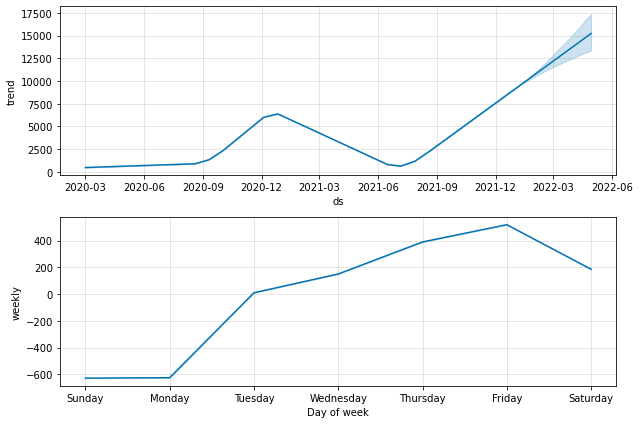

In [179]:
future_baseline = prop_base.make_future_dataframe(periods=len(covid_test))
future_baseline['ds'] = pd.to_datetime(future_baseline['ds'])
forecast_baseline = prop_base.predict(future_baseline)
prop_base.plot_components(forecast_baseline);

In [180]:
performance_baseline = pd.concat([covid_test, forecast_baseline[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(16)], keys=['ds'])

In [181]:
print('MAE = ', mean_absolute_error(performance_baseline['y'], performance_baseline['yhat']))
print('MASE = ', mase(performance_baseline['y'], performance_baseline['yhat']))
print('RMSE = ', np.sqrt(mean_squared_error(performance_baseline['yhat'], performance_baseline['y'])))

MAE =  11044.314984968829
MASE =  7.434915527434302
RMSE =  11867.955883078283


## Tuned Univariate

In [182]:
prop_base.changepoints

21    2020-03-22
43    2020-04-13
64    2020-05-04
86    2020-05-26
107   2020-06-16
128   2020-07-07
150   2020-07-29
171   2020-08-19
193   2020-09-10
214   2020-10-01
235   2020-10-22
257   2020-11-13
278   2020-12-04
300   2020-12-26
321   2021-01-16
342   2021-02-06
364   2021-02-28
385   2021-03-21
407   2021-04-12
428   2021-05-03
449   2021-05-24
471   2021-06-15
492   2021-07-06
514   2021-07-28
535   2021-08-18
Name: ds, dtype: datetime64[ns]

In [183]:
# COVID time window
COVID = pd.DataFrame({
    'holiday': 'COVID',
    'ds': pd.to_datetime(['2020-03-15']),
    'lower_window': -15,
    'upper_window': 15,
})

# Super Bowl time window updated to 2021-22 since the 2020 one is out of our window
superbowl = pd.DataFrame({
    'holiday': 'superbowl',
    'ds': pd.to_datetime(['2021-02-07', '2022-02-13']),
    'lower_window': -7,
    'upper_window': 1,
})

# Combine all events
events = pd.concat((COVID, superbowl))

# Take a look at the events data
events

,holiday,ds,lower_window,upper_window
0,COVID,2020-03-15,-15,15
0,superbowl,2021-02-07,-7,1
1,superbowl,2022-02-13,-7,1


In [184]:
tss = TimeSeriesSplit(n_splits = 5)

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'holidays_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'seasonality_mode': ['additive', 'multiplicative'],
}

all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  

for params in all_params:
    m = Prophet(**params).fit(covid_train)  
    df_cv = cross_validation(m, initial='200 days', period='20 days', horizon = '10 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

16:09:05 - cmdstanpy - INFO - Chain [1] start processing
16:09:05 - cmdstanpy - INFO - Chain [1] done processing
16:09:05 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:09:05 - cmdstanpy - INFO - Chain [1] start processing
16:09:06 - cmdstanpy - INFO - Chain [1] done processing

KeyboardInterrupt



In [ ]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

In [193]:
prophet_tuned = Prophet(yearly_seasonality=True, n_changepoints=25, changepoint_prior_scale=0.5, seasonality_prior_scale=1.0, holidays_prior_scale=0.01, seasonality_mode='multiplicative')
prophet_tuned.add_country_holidays(country_name='US')

prophet_tuned.fit(covid_train)
prop_season_train = prophet_tuned.predict(covid_train)
prop_season_test = prophet_tuned.predict(covid_test)

16:11:16 - cmdstanpy - INFO - Chain [1] start processing
16:11:16 - cmdstanpy - INFO - Chain [1] done processing


<AxesSubplot:>

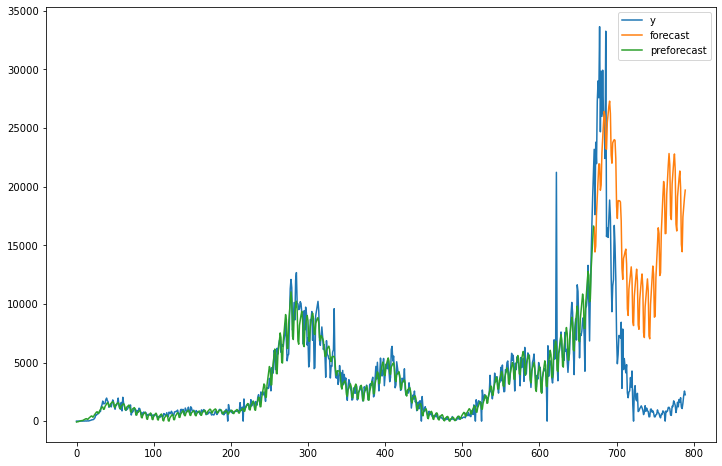

In [194]:
prophet_df_season = pd.DataFrame(covid_df)
prophet_df_season = prophet_df_season.rename(columns={'Date': 'ds', 'PEOPLE_POSITIVE_NEW_CASES_COUNT': 'y'})
prophet_df_season['ds'] = pd.to_datetime(prophet_df_season['ds'])

prophet_df_season['forecast'] = prop_season_test['yhat']
length2 = len(prophet_df_season) - len(prop_season_test)
forecast2 = pd.concat([pd.Series([np.nan] * length2), prop_season_test['yhat']], ignore_index=True)
prophet_df_season['forecast'] = forecast2
prophet_df_season['forecast'] = np.clip(prophet_df_season['forecast'], 0, None)


prophet_df_season['preforecast']=prop_season_train['yhat']

prophet_df_season[['y','forecast', 'preforecast']].plot(figsize=(12,8))

<AxesSubplot:>

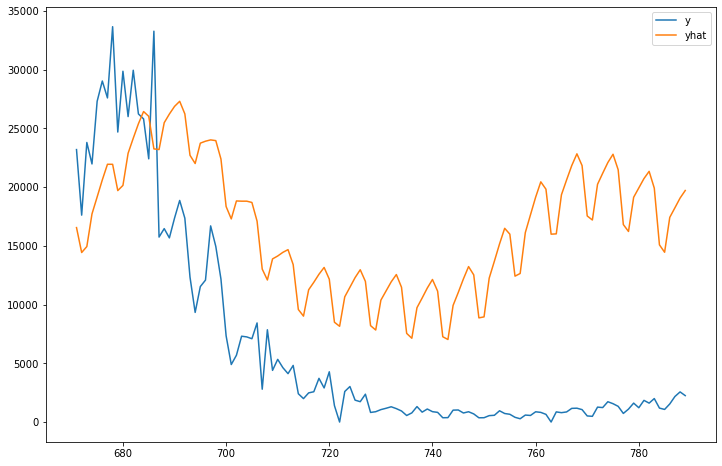

In [195]:
graph_df = pd.DataFrame(covid_test)
graph_df['yhat'] = prop_season_test['yhat'].values
graph_df['yhat'] = np.clip(graph_df['yhat'], 0, None)
graph_df[['y','yhat']].plot(figsize=(12,8))

In [196]:
tuned_df = prophet_tuned.make_future_dataframe(periods=len(covid_test))
tuned_df['ds'] = pd.to_datetime(tuned_df['ds'])
forecast_tuned = prop_base.predict(tuned_df)

tunned_performance = pd.concat([covid_test, forecast_tuned[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(119)], keys=['ds'])
print('MAE = ', mean_absolute_error(tunned_performance['y'], tunned_performance['yhat']))
print('MASE = ', mase(tunned_performance['y'], tunned_performance['yhat']))
print('RMSE = ', np.sqrt(mean_squared_error(tunned_performance['yhat'], tunned_performance['y'])))

MAE =  11510.03137105457
MASE =  7.748430851381689
RMSE =  12435.697776749646


## Baseline Multivariate 

In [ ]:
import os
os._exit(00)

In [198]:
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd
import numpy as np
import datetime
import requests
import warnings

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder

from sklearn.model_selection import train_test_split
from prophet import Prophet
import xgboost as xgb

from prophet.plot import plot_plotly, add_changepoints_to_plot
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings('ignore')

from prophet import Prophet
from prophet.plot import plot_plotly, add_changepoints_to_plot
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error

In [199]:
def mase(actual, forecast):
    n = len(actual)
    numerator = np.mean(np.abs(actual - forecast))
    denominator = np.mean(np.abs(np.diff(actual)))
    return numerator / denominator

In [200]:
covid_df = pd.read_csv('penn_multi_df.csv', parse_dates=['Date'])
covid_df.drop(columns = ['PROVINCE_STATE_NAME'], inplace = True)
covid_df['PEOPLE_POSITIVE_NEW_CASES_COUNT'] = np.clip(covid_df['PEOPLE_POSITIVE_NEW_CASES_COUNT'], 0, None)
covid_df = covid_df.rename(columns={'Date': 'ds', 'PEOPLE_POSITIVE_NEW_CASES_COUNT': 'y'})
covid_df

,ds,Completeness_pct,Administered_Dose1_Recip,Administered_Dose1_Recip_5Plus,Administered_Dose1_Recip_12Plus,Administered_Dose1_Recip_18Plus,Administered_Dose1_Recip_65Plus,Series_Complete_Yes,Series_Complete_5Plus,Series_Complete_5to17,...,new_cases_50_lag,new_cases_150_lag,new_cases_350_lag,new_deaths_1_lag,new_deaths_2_lag,new_deaths_3_lag,new_deaths_4_lag,new_deaths_7_lag,new_deaths_30_lag,new_deaths_50_lag
0,2020-03-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-03-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-03-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN
3,2020-03-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN
4,2020-03-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
785,2022-04-25,6351.6,10122441.0,10119873.0,9747785.0,9135527.0,2522725.0,8282045.0,8281102.0,813246.0,...,556.0,6122.0,1681.0,6.0,10.0,14.0,28.0,0.0,28.0,75.0
786,2022-04-26,6351.6,10124587.0,10122005.0,9749772.0,9137400.0,2523502.0,8284241.0,8283287.0,813484.0,...,778.0,5143.0,2216.0,2.0,6.0,10.0,14.0,51.0,1.0,0.0
787,2022-04-27,6351.6,10127299.0,10124704.0,9752246.0,9139684.0,2524356.0,8287191.0,8286229.0,813821.0,...,1315.0,4159.0,1883.0,6.0,2.0,6.0,10.0,11.0,2.0,92.0
788,2022-04-28,6351.6,10128208.0,10125605.0,9753099.0,9140507.0,2524735.0,8288066.0,8287097.0,813912.0,...,841.0,5252.0,2563.0,13.0,6.0,2.0,6.0,28.0,27.0,38.0


In [201]:
train_size = int(len(covid_df)* 0.85)
covid_train, covid_test = covid_df[0:train_size], covid_df[train_size:]

In [202]:
covid_train = covid_train[['ds', 'y', 'new_cases_50_std', 'PEOPLE_DEATH_NEW_COUNT', 'relative_humidity', 'average_temperature_celsius', 'new_cases_10_std', 'new_hospitalized_patients', 'Series_Complete_5Plus', 'new_deaths_10_mean', 'current_intensive_care_patients', 'new_cases_10_min', 'new_cases_10_mean', 'new_cases_10_max', 'minimum_temperature_celsius']]
covid_test = covid_test[['ds', 'y', 'new_cases_50_std', 'PEOPLE_DEATH_NEW_COUNT', 'relative_humidity', 'average_temperature_celsius', 'new_cases_10_std', 'new_hospitalized_patients', 'Series_Complete_5Plus', 'new_deaths_10_mean', 'current_intensive_care_patients', 'new_cases_10_min', 'new_cases_10_mean', 'new_cases_10_max', 'minimum_temperature_celsius']]

In [203]:
multi_prop = Prophet(yearly_seasonality=True, weekly_seasonality=True)

regressors = ['new_cases_50_std', 'PEOPLE_DEATH_NEW_COUNT', 'relative_humidity', 'average_temperature_celsius', 'new_cases_10_std', 'new_hospitalized_patients', 'Series_Complete_5Plus', 'new_deaths_10_mean', 'current_intensive_care_patients', 'new_cases_10_min', 'new_cases_10_mean', 'new_cases_10_max', 'minimum_temperature_celsius']
for regressor in regressors:
    multi_prop.add_regressor(regressor, standardize=False)
    
multi_prop.fit(covid_train)

16:18:07 - cmdstanpy - INFO - Chain [1] start processing
16:18:07 - cmdstanpy - INFO - Chain [1] done processing
16:18:07 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:18:07 - cmdstanpy - INFO - Chain [1] start processing
16:18:14 - cmdstanpy - INFO - Chain [1] done processing


In [204]:
future_multi = multi_prop.make_future_dataframe(periods=len(covid_test))
future_multi = pd.merge(future_multi, covid_df[['ds', 'new_cases_50_std', 'PEOPLE_DEATH_NEW_COUNT', 'relative_humidity', 'average_temperature_celsius', 'new_cases_10_std', 'new_hospitalized_patients', 'Series_Complete_5Plus', 'new_deaths_10_mean', 'current_intensive_care_patients', 'new_cases_10_min', 'new_cases_10_mean', 'new_cases_10_max', 'minimum_temperature_celsius']], on='ds', how='inner')
forecast_multi = multi_prop.predict(future_multi)
forecast_multi['yhat'] = np.clip(forecast_multi['yhat'], 0, None)


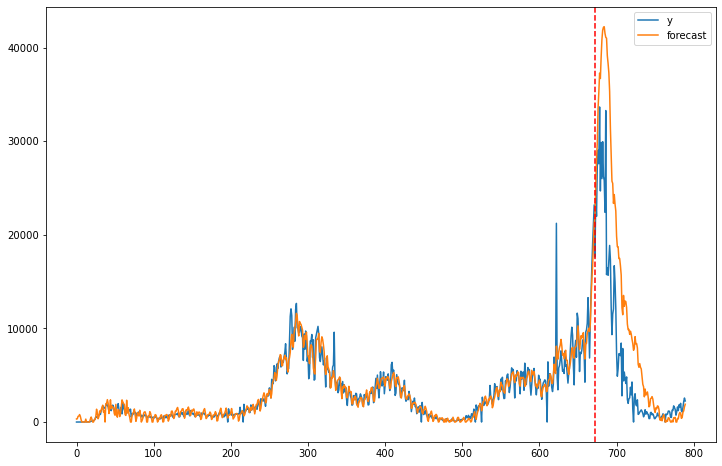

In [205]:
prophet_df_multi = pd.DataFrame(covid_df)
prophet_df_multi = prophet_df_multi.rename(columns={'Date': 'ds', 'PEOPLE_POSITIVE_NEW_CASES_COUNT': 'y'})
prophet_df_multi['ds'] = pd.to_datetime(prophet_df_multi['ds'])

prophet_df_multi['forecast']=forecast_multi['yhat']

prophet_df_multi[['y', 'forecast']].plot(figsize=(12,8))

plt.axvline(x=672, color='red', linestyle='--', label='Split Point')
plt.show()

In [206]:
graph_df = pd.DataFrame(covid_test['y'])
#graph_df['yhat'] = forecast_multi['yhat'].tail(119).values
#graph_df[['y','yhat']].plot(figsize=(12,8))
covid_test

,ds,y,new_cases_50_std,PEOPLE_DEATH_NEW_COUNT,relative_humidity,average_temperature_celsius,new_cases_10_std,new_hospitalized_patients,Series_Complete_5Plus,new_deaths_10_mean,current_intensive_care_patients,new_cases_10_min,new_cases_10_mean,new_cases_10_max,minimum_temperature_celsius
671,2022-01-01,23189,4554.777187,9,93.673739,9.790123,5314.502949,699.0,7730994.0,93.1,1011.0,6839.0,14565.4,23189.0,6.592593
672,2022-01-02,17611,4379.050508,1,88.659090,9.216049,5189.123819,732.0,7730994.0,75.5,1042.0,6839.0,15271.7,23189.0,3.382716
673,2022-01-03,23795,4829.811228,84,62.180663,-1.339506,5773.529485,829.0,7731313.0,74.9,1052.0,6839.0,16322.6,23795.0,-4.086420
674,2022-01-04,21967,5088.566024,169,59.336181,-3.308642,5531.500581,909.0,7759713.0,91.8,1082.0,6839.0,17533.7,23795.0,-7.598765
675,2022-01-05,27300,5647.397621,143,68.867781,-0.067901,4882.124351,882.0,7767482.0,106.1,1081.0,11079.0,19579.8,27300.0,-5.895062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
785,2022-04-25,1072,427.162199,2,62.121561,16.432099,388.633847,65.0,8281102.0,13.6,62.0,732.0,1370.4,1997.0,8.740741
786,2022-04-26,1538,435.694053,6,78.776408,13.858025,391.883259,87.0,8283287.0,12.8,63.0,732.0,1390.6,1997.0,10.975309
787,2022-04-27,2173,467.007152,13,52.458461,7.506173,387.714113,104.0,8286229.0,14.1,55.0,1072.0,1534.7,2173.0,4.000000
788,2022-04-28,2564,519.735853,12,38.526229,5.827160,472.471622,108.0,8287097.0,15.3,63.0,1072.0,1681.1,2564.0,1.271605


In [207]:
graph_df['yhat'] = forecast_multi['yhat'].tail(119).values
#graph_df[['y','yhat']].plot(figsize=(12,8))
covid_test

,ds,y,new_cases_50_std,PEOPLE_DEATH_NEW_COUNT,relative_humidity,average_temperature_celsius,new_cases_10_std,new_hospitalized_patients,Series_Complete_5Plus,new_deaths_10_mean,current_intensive_care_patients,new_cases_10_min,new_cases_10_mean,new_cases_10_max,minimum_temperature_celsius
671,2022-01-01,23189,4554.777187,9,93.673739,9.790123,5314.502949,699.0,7730994.0,93.1,1011.0,6839.0,14565.4,23189.0,6.592593
672,2022-01-02,17611,4379.050508,1,88.659090,9.216049,5189.123819,732.0,7730994.0,75.5,1042.0,6839.0,15271.7,23189.0,3.382716
673,2022-01-03,23795,4829.811228,84,62.180663,-1.339506,5773.529485,829.0,7731313.0,74.9,1052.0,6839.0,16322.6,23795.0,-4.086420
674,2022-01-04,21967,5088.566024,169,59.336181,-3.308642,5531.500581,909.0,7759713.0,91.8,1082.0,6839.0,17533.7,23795.0,-7.598765
675,2022-01-05,27300,5647.397621,143,68.867781,-0.067901,4882.124351,882.0,7767482.0,106.1,1081.0,11079.0,19579.8,27300.0,-5.895062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
785,2022-04-25,1072,427.162199,2,62.121561,16.432099,388.633847,65.0,8281102.0,13.6,62.0,732.0,1370.4,1997.0,8.740741
786,2022-04-26,1538,435.694053,6,78.776408,13.858025,391.883259,87.0,8283287.0,12.8,63.0,732.0,1390.6,1997.0,10.975309
787,2022-04-27,2173,467.007152,13,52.458461,7.506173,387.714113,104.0,8286229.0,14.1,55.0,1072.0,1534.7,2173.0,4.000000
788,2022-04-28,2564,519.735853,12,38.526229,5.827160,472.471622,108.0,8287097.0,15.3,63.0,1072.0,1681.1,2564.0,1.271605


,ds,y,new_cases_50_std,PEOPLE_DEATH_NEW_COUNT,relative_humidity,average_temperature_celsius,new_cases_10_std,new_hospitalized_patients,Series_Complete_5Plus,new_deaths_10_mean,current_intensive_care_patients,new_cases_10_min,new_cases_10_mean,new_cases_10_max,minimum_temperature_celsius
671,2022-01-01,23189,4554.777187,9,93.673739,9.790123,5314.502949,699.0,7730994.0,93.1,1011.0,6839.0,14565.4,23189.0,6.592593
672,2022-01-02,17611,4379.050508,1,88.659090,9.216049,5189.123819,732.0,7730994.0,75.5,1042.0,6839.0,15271.7,23189.0,3.382716
673,2022-01-03,23795,4829.811228,84,62.180663,-1.339506,5773.529485,829.0,7731313.0,74.9,1052.0,6839.0,16322.6,23795.0,-4.086420
674,2022-01-04,21967,5088.566024,169,59.336181,-3.308642,5531.500581,909.0,7759713.0,91.8,1082.0,6839.0,17533.7,23795.0,-7.598765
675,2022-01-05,27300,5647.397621,143,68.867781,-0.067901,4882.124351,882.0,7767482.0,106.1,1081.0,11079.0,19579.8,27300.0,-5.895062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
785,2022-04-25,1072,427.162199,2,62.121561,16.432099,388.633847,65.0,8281102.0,13.6,62.0,732.0,1370.4,1997.0,8.740741
786,2022-04-26,1538,435.694053,6,78.776408,13.858025,391.883259,87.0,8283287.0,12.8,63.0,732.0,1390.6,1997.0,10.975309
787,2022-04-27,2173,467.007152,13,52.458461,7.506173,387.714113,104.0,8286229.0,14.1,55.0,1072.0,1534.7,2173.0,4.000000
788,2022-04-28,2564,519.735853,12,38.526229,5.827160,472.471622,108.0,8287097.0,15.3,63.0,1072.0,1681.1,2564.0,1.271605


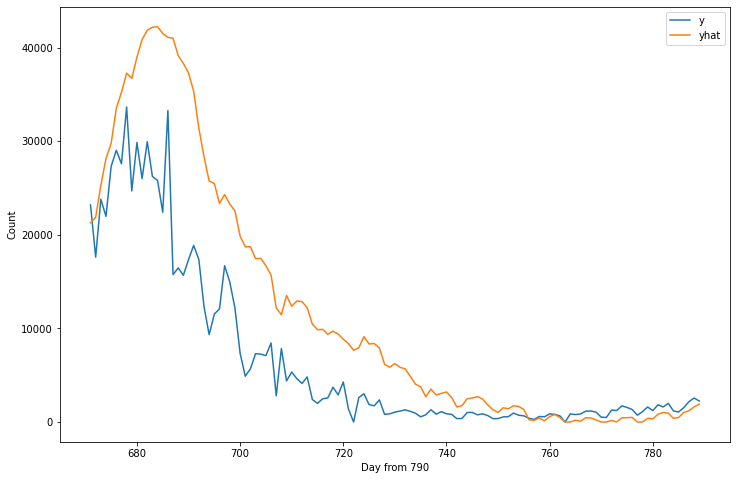

In [208]:
graph_df[['y','yhat']].plot(figsize=(12,8))
plt.xlabel('Day from 790')
plt.ylabel('Count')
covid_test

In [210]:
performance_multi = pd.merge(covid_test, forecast_multi[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-119:], on='ds')
print('MAE = ', mean_absolute_error(performance_multi['y'], performance_multi['yhat']))
print('MASE = ', mase(performance_multi['y'], performance_multi['yhat']))
print('RMSE = ', np.sqrt(mean_squared_error(performance_multi['yhat'], performance_multi['y'])))

MAE =  5481.90795713444
MASE =  3.6903622040782946
RMSE =  7913.569675030268


## Tuned Multivariate

In [76]:
import itertools
import numpy as np
import pandas as pd
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics


param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'holidays_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'seasonality_mode': ['additive', 'multiplicative'],
}

all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = [] 

for params in all_params:
    m = Prophet(**params).fit(covid_train)  
    df_cv = cross_validation(m, initial='200 days', period='20 days', horizon = '10 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

15:38:51 - cmdstanpy - INFO - Chain [1] start processing
15:38:51 - cmdstanpy - INFO - Chain [1] done processing
15:38:51 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
15:38:51 - cmdstanpy - INFO - Chain [1] start processing
15:38:52 - cmdstanpy - INFO - Chain [1] done processing
15:39:00 - cmdstanpy - INFO - Chain [1] start processing
15:39:00 - cmdstanpy - INFO - Chain [1] done processing
15:39:00 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
15:39:00 - cmdstanpy - INFO - Chain [1] start processing
15:39:01 - cmdstanpy - INFO - Chain [1] done processing
15:39:10 - cmdstanpy - INFO - Chain [1] start processing
15:39:10 - cmdstanpy - INFO - Chain [1] done processing
15:39:10 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abn

Optimization terminated abnormally. Falling back to Newton.
15:42:46 - cmdstanpy - INFO - Chain [1] start processing
15:42:47 - cmdstanpy - INFO - Chain [1] done processing
15:42:57 - cmdstanpy - INFO - Chain [1] start processing
15:42:57 - cmdstanpy - INFO - Chain [1] done processing
15:42:57 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
15:42:57 - cmdstanpy - INFO - Chain [1] start processing
15:42:58 - cmdstanpy - INFO - Chain [1] done processing
15:43:07 - cmdstanpy - INFO - Chain [1] start processing
15:43:07 - cmdstanpy - INFO - Chain [1] done processing
15:43:07 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
15:43:07 - cmdstanpy - INFO - Chain [1] start processing
15:43:08 - cmdstanpy - INFO - Chain [1] done processing
15:43:18 - cmdstanpy - INFO - Chain [1] start processing
15:43:

15:49:37 - cmdstanpy - INFO - Chain [1] done processing
15:49:45 - cmdstanpy - INFO - Chain [1] start processing
15:49:45 - cmdstanpy - INFO - Chain [1] done processing
15:49:54 - cmdstanpy - INFO - Chain [1] start processing
15:49:54 - cmdstanpy - INFO - Chain [1] done processing
15:50:02 - cmdstanpy - INFO - Chain [1] start processing
15:50:02 - cmdstanpy - INFO - Chain [1] done processing
15:50:09 - cmdstanpy - INFO - Chain [1] start processing
15:50:10 - cmdstanpy - INFO - Chain [1] done processing
15:50:18 - cmdstanpy - INFO - Chain [1] start processing
15:50:18 - cmdstanpy - INFO - Chain [1] done processing
15:50:25 - cmdstanpy - INFO - Chain [1] start processing
15:50:26 - cmdstanpy - INFO - Chain [1] done processing
15:50:35 - cmdstanpy - INFO - Chain [1] start processing
15:50:35 - cmdstanpy - INFO - Chain [1] done processing
15:50:43 - cmdstanpy - INFO - Chain [1] start processing
15:50:43 - cmdstanpy - INFO - Chain [1] done processing
15:50:52 - cmdstanpy - INFO - Chain [1] 

     changepoint_prior_scale  seasonality_prior_scale  holidays_prior_scale  \
0                      0.001                     0.01                  0.01   
1                      0.001                     0.01                  0.01   
2                      0.001                     0.01                  0.10   
3                      0.001                     0.01                  0.10   
4                      0.001                     0.01                  1.00   
..                       ...                      ...                   ...   
123                    0.500                    10.00                  0.10   
124                    0.500                    10.00                  1.00   
125                    0.500                    10.00                  1.00   
126                    0.500                    10.00                 10.00   
127                    0.500                    10.00                 10.00   

    seasonality_mode         rmse  
0           add

In [77]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


In [166]:
COVID = pd.DataFrame({
    'holiday': 'COVID',
    'ds': pd.to_datetime(['2020-03-15']),
    'lower_window': -15,
    'upper_window': 15,
})

superbowl = pd.DataFrame({
    'holiday': 'superbowl',
    'ds': pd.to_datetime(['2021-02-07', '2022-02-13']),
    'lower_window': -7,
    'upper_window': 1,
})

events = pd.concat((COVID, superbowl))
events

,holiday,ds,lower_window,upper_window
0,COVID,2020-03-15,-15,15
0,superbowl,2021-02-07,-7,1
1,superbowl,2022-02-13,-7,1


In [167]:
#model_holiday_tuned = Prophet(yearly_seasonality=True, weekly_seasonality=True, 
#                              changepoint_prior_scale=0.5, seasonality_prior_scale=1.0, 
#                              holidays_prior_scale=0.01, seasonality_mode='additive', 
 #                             n_changepoints=25)
model_holiday_tuned = Prophet(changepoint_prior_scale=0.5, seasonality_prior_scale=1.0, 
                              holidays_prior_scale=0.01, seasonality_mode='multiplicative')
model_holiday_tuned.add_country_holidays(country_name='US')

regressors = ['new_cases_50_std', 'PEOPLE_DEATH_NEW_COUNT', 'relative_humidity', 'average_temperature_celsius', 'new_cases_10_std', 'new_hospitalized_patients', 'Series_Complete_5Plus', 'new_deaths_10_mean', 'current_intensive_care_patients', 'new_cases_10_min', 'new_cases_10_mean', 'new_cases_10_max', 'minimum_temperature_celsius']
for regressor in regressors:
    model_holiday_tuned.add_regressor(regressor, standardize=False)

model_holiday_tuned.fit(covid_train)

16:07:43 - cmdstanpy - INFO - Chain [1] start processing
16:07:43 - cmdstanpy - INFO - Chain [1] done processing
16:07:43 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:07:43 - cmdstanpy - INFO - Chain [1] start processing
16:07:49 - cmdstanpy - INFO - Chain [1] done processing


In [168]:
future_holiday_tuned = model_holiday_tuned.make_future_dataframe(periods=len(covid_test))

future_holiday_tuned = pd.merge(future_holiday_tuned, covid_df[['ds', 'new_cases_50_std', 'PEOPLE_DEATH_NEW_COUNT', 'relative_humidity', 'average_temperature_celsius', 'new_cases_10_std', 'new_hospitalized_patients', 'Series_Complete_5Plus', 'new_deaths_10_mean', 'current_intensive_care_patients', 'new_cases_10_min', 'new_cases_10_mean', 'new_cases_10_max', 'minimum_temperature_celsius']], on='ds', how='inner')
future_holiday_tuned = future_holiday_tuned.fillna(method='ffill')

forecast_holiday_tuned = model_holiday_tuned.predict(future_holiday_tuned)
forecast_holiday_tuned['yhat'] = np.clip(forecast_holiday_tuned['yhat'], 0, None)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Christmas Day (observed),...,relative_humidity,relative_humidity_lower,relative_humidity_upper,weekly,weekly_lower,weekly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2020-03-01,-64.483527,-1193.396087,1133.733723,-64.483527,-64.483527,0.0,0.0,0.0,0.0,...,0.615329,0.615329,0.615329,-0.704342,-0.704342,-0.704342,0.0,0.0,0.0,0.000000
1,2020-03-02,-50.933609,-1139.022711,1103.518968,-50.933609,-50.933609,0.0,0.0,0.0,0.0,...,0.615329,0.615329,0.615329,-0.617717,-0.617717,-0.617717,0.0,0.0,0.0,0.000000
2,2020-03-03,-37.383691,-1203.895619,1037.626547,-37.383691,-37.383691,0.0,0.0,0.0,0.0,...,0.728357,0.728357,0.728357,0.025730,0.025730,0.025730,0.0,0.0,0.0,0.000000
3,2020-03-04,-23.833773,-1144.083162,1108.305199,-23.833773,-23.833773,0.0,0.0,0.0,0.0,...,0.462967,0.462967,0.462967,0.050553,0.050553,0.050553,0.0,0.0,0.0,0.000000
4,2020-03-05,-10.283854,-1156.695489,1158.655153,-10.283854,-10.283854,0.0,0.0,0.0,0.0,...,0.427953,0.427953,0.427953,0.367025,0.367025,0.367025,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
785,2022-04-25,1927.128671,134.882019,5586.503734,233.573202,3755.093941,0.0,0.0,0.0,0.0,...,0.514670,0.514670,0.514670,-0.617717,-0.617717,-0.617717,0.0,0.0,0.0,2788.261181
786,2022-04-26,1931.286690,406.626130,8857.289134,206.894145,3787.262466,0.0,0.0,0.0,0.0,...,0.652654,0.652654,0.652654,0.025730,0.025730,0.025730,0.0,0.0,0.0,4513.857890
787,2022-04-27,1935.444710,150.806209,8300.905816,183.626034,3827.019553,0.0,0.0,0.0,0.0,...,0.434613,0.434613,0.434613,0.050553,0.050553,0.050553,0.0,0.0,0.0,4235.386063
788,2022-04-28,1939.602729,135.524009,9228.176594,172.569931,3858.692580,0.0,0.0,0.0,0.0,...,0.319186,0.319186,0.319186,0.367025,0.367025,0.367025,0.0,0.0,0.0,4722.261699


In [169]:
performance_holiday_tuned = pd.merge(covid_test, forecast_holiday_tuned[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-119:], on='ds')
print('MAE =', mean_absolute_error(performance_holiday_tuned['y'], performance_holiday_tuned['yhat']))
print('MASE = ', mase(performance_holiday_tuned['y'], performance_holiday_tuned['yhat']))
print('RMSE = ', np.sqrt(mean_squared_error(performance_multi['yhat'], performance_multi['y'])))

MAE = 4540.482211859307
MASE =  3.0566043928425035
RMSE =  7913.569675030268


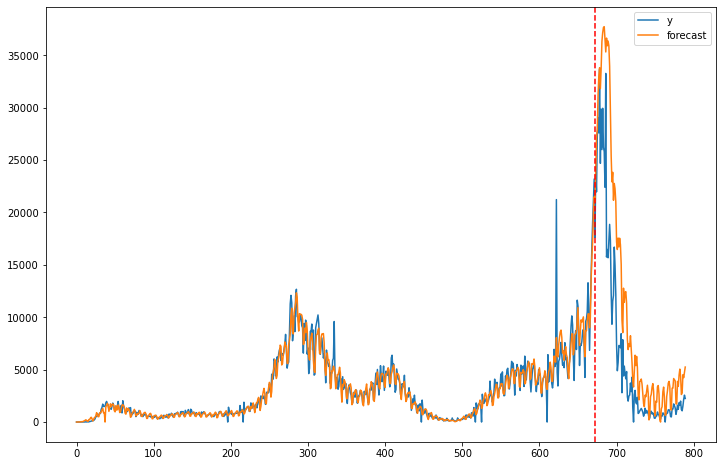

In [170]:
prophet_df_multi_tuned = pd.DataFrame(covid_df)
prophet_df_multi_tuned = prophet_df_multi_tuned.rename(columns={'Date': 'ds', 'PEOPLE_POSITIVE_NEW_CASES_COUNT': 'y'})
prophet_df_multi_tuned['ds'] = pd.to_datetime(prophet_df_multi_tuned['ds'])

prophet_df_multi_tuned['forecast']=forecast_holiday_tuned['yhat']

prophet_df_multi_tuned[['y', 'forecast']].plot(figsize=(12,8))

plt.axvline(x=672, color='red', linestyle='--', label='Split Point')
plt.show()

<AxesSubplot:>

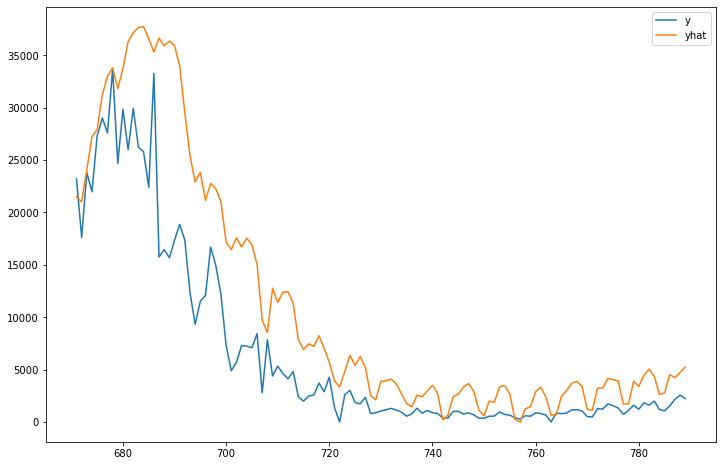

In [171]:
graph_df = pd.DataFrame(covid_test)
graph_df['yhat'] = prophet_df_multi_tuned['forecast'].tail(119).values
graph_df[['y','yhat']].plot(figsize=(12,8))